Book version: https://www.learnpytorch.io/02_pytorch_classification/

Ground truth notebook: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/02_pytorch_classification.ipynb

## 1. Make Classification Data And Get It Ready

In [1]:
import torch
import torch.nn as nn
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)
print(len(X), len(y))
print(X[:5])
print(y[:5])

1000 1000
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [4]:
# Make DataFrame of circle data
circles = pd.DataFrame({"X1": X[:,0], "X2": X[:,1], "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [5]:
# Check different labels
circles.label.value_counts() # As we can see, this is a binary classification problem

label
1    500
0    500
Name: count, dtype: int64

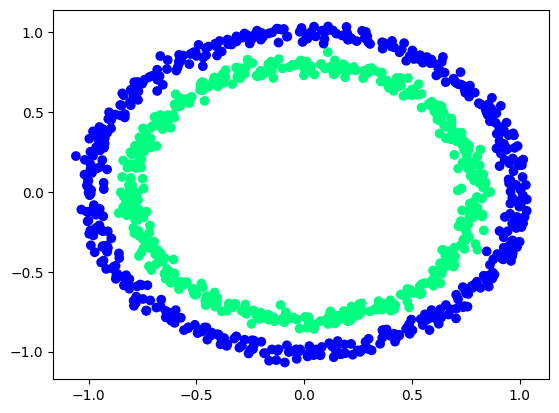

In [6]:
# Visualize with a plot
plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap=plt.cm.winter) # check list(matplotlib.colormap) for list of available color maps

We want our model to separate the blue dots from the greend dots.

In [7]:
# Check input and output shapes
X.shape, y.shape # X has 2 features, y only has 1 (scalar)

((1000, 2), (1000,))

In [8]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)
type(X), type(y)

(torch.Tensor, torch.Tensor)

In [9]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.2)

In [10]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [11]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

## 2. Build Model


In [12]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=4) # in_features = 2 because our X has 2 features, out_features=4 is arbitrary
        self.layer_2 = nn.Linear(in_features=4, out_features=1) # in_features = 4 because previous layer has 4 outputs, out_features 1 is our prediction (shape of y)
        
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

In [13]:
model_0 = CircleModelV0().to(device)
model_0, next(model_0.parameters()).device

(CircleModelV0(
   (layer_1): Linear(in_features=2, out_features=4, bias=True)
   (layer_2): Linear(in_features=4, out_features=1, bias=True)
 ),
 device(type='cpu'))

In [14]:
# Alternative syntax for the model code above
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=4),
    nn.Linear(in_features=4, out_features=1)
).to(device)

model_0, next(model_0.parameters()).device

(Sequential(
   (0): Linear(in_features=2, out_features=4, bias=True)
   (1): Linear(in_features=4, out_features=1, bias=True)
 ),
 device(type='cpu'))

In [15]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.4273,  0.6480],
                      [-0.4616, -0.1972],
                      [-0.0236, -0.5824],
                      [-0.1081, -0.1615]])),
             ('0.bias', tensor([ 0.6920, -0.0223, -0.5250, -0.1910])),
             ('1.weight', tensor([[ 0.3631, -0.0519, -0.3276,  0.2621]])),
             ('1.bias', tensor([-0.3047]))])

In [16]:
# Make predictions with untrained model
model_0.eval()
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(untrained_preds[:5])
print(untrained_preds.shape, y_test.shape)

tensor([[ 0.3955],
        [ 0.4455],
        [ 0.0524],
        [ 0.4936],
        [-0.2844]])
torch.Size([200, 1]) torch.Size([200])


As you can see, predictions are completely off and the shape is also wrong. We'll fix this later. Let's train the model for now.

In [17]:
loss_fn = nn.BCEWithLogitsLoss() # Binary Cross Entropy combined with Sigmoid. BCELoss expect input in 0 or 1. But that's not the case with our current model.
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [18]:
# Calculate Loss
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train Model

### 3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

Logits are the raw scores or values that a model outputs directly from the final linear layer. They are typically not probabilities but rather values that can be transformed into probabilities using an activation function like the softmax (for multiclass) or sigmoid function (for 0 and 1).

In [19]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.3955],
        [ 0.4455],
        [ 0.0524],
        [ 0.4936],
        [-0.2844]])

In [20]:
# Use sigmoid on model logits, to get probability distribution
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5976],
        [0.6096],
        [0.5131],
        [0.6210],
        [0.4294]])

In [21]:
# Thresholding after sigmoid. Since this is a binary classification problem, our answer can only be 0 or 1
y_pred_labels = (y_pred_probs > 0.5).int()  # Apply threshold
y_pred_labels.squeeze() # get rid of extra dimension

tensor([1, 1, 1, 1, 0], dtype=torch.int32)

This way we can compare our model's prediction with `y_test`.

In [22]:
torch.eq(y_pred_labels.squeeze(), y_test[:5])

tensor([ True, False,  True, False, False])

### 3.2 Build Training And Testing Loop

In [23]:
def train_model(model, X_train, y_train, X_valid, y_valid, epochs, loss_fn, optimizer):    
    for epoch in range(epochs):
        ### Training
        model.train()
        
        # Forward pass
        y_logits = model(X_train).squeeze() # remove extra dimension for loss function
        y_pred = torch.round(torch.sigmoid(y_logits)) # logits > pred probs -> pred labels
        
        # Calc Loss / Acc
        loss = loss_fn(y_logits, y_train)
        acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        ### Testing
        model.eval()
        with torch.inference_mode():
            test_logits = model(X_valid).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))
            test_loss = loss_fn(test_logits, y_valid)
            test_acc = accuracy_fn(y_true=y_valid, y_pred=test_pred)
            
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test loss {test_loss:.5f} | Test accuracy {test_acc:.2f}%")

In [24]:
train_model(model_0, X_train, y_train, X_test, y_test, 100, loss_fn, optimizer)

Epoch 0: Loss: 0.70109 | Accuracy: 51.25% | Test loss 0.70907 | Test accuracy 50.50%
Epoch 10: Loss: 0.69879 | Accuracy: 50.88% | Test loss 0.70576 | Test accuracy 48.50%
Epoch 20: Loss: 0.69761 | Accuracy: 50.50% | Test loss 0.70391 | Test accuracy 48.00%
Epoch 30: Loss: 0.69687 | Accuracy: 49.88% | Test loss 0.70269 | Test accuracy 49.00%
Epoch 40: Loss: 0.69633 | Accuracy: 50.38% | Test loss 0.70179 | Test accuracy 50.00%
Epoch 50: Loss: 0.69589 | Accuracy: 50.00% | Test loss 0.70107 | Test accuracy 49.50%
Epoch 60: Loss: 0.69553 | Accuracy: 49.88% | Test loss 0.70047 | Test accuracy 49.00%
Epoch 70: Loss: 0.69522 | Accuracy: 49.75% | Test loss 0.69996 | Test accuracy 48.50%
Epoch 80: Loss: 0.69496 | Accuracy: 49.75% | Test loss 0.69951 | Test accuracy 49.00%
Epoch 90: Loss: 0.69473 | Accuracy: 50.00% | Test loss 0.69911 | Test accuracy 48.50%


The accuracy barely moves above 50% on each data split. And because we're working with a balanced binary classification problem, it means our model is performing as good as random guessing.

## 4. Make Predictions And Evaluate The Model

It looks like our model isn't learning anything. Let's inspect it by making some predictions and creating some visuals.

To do so, we'll write some code to download and import the helper_functions.py script from the Learn PyTorch for Deep Learning repo.

It contains a helpful function called plot_decision_boundary() which creates a NumPy meshgrid to visually plot the different points where our model is predicting certain classes.

We'll also import plot_predictions() which we wrote in notebook 01 to use later.

In [25]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

In [26]:
??plot_predictions

Signature:
plot_predictions(
    train_data,
    train_labels,
    test_data,
    test_labels,
    predictions=None,
)
Source:   
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})
File:      /kaggle/working/helper_functions.py
Type:      function

In [27]:
??plot_decision_boundary

Signature:
plot_decision_boundary(
    model: torch.nn.modules.module.Module,
    X: torch.Tensor,
    y: torch.Tensor,
)
Source:   
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

  

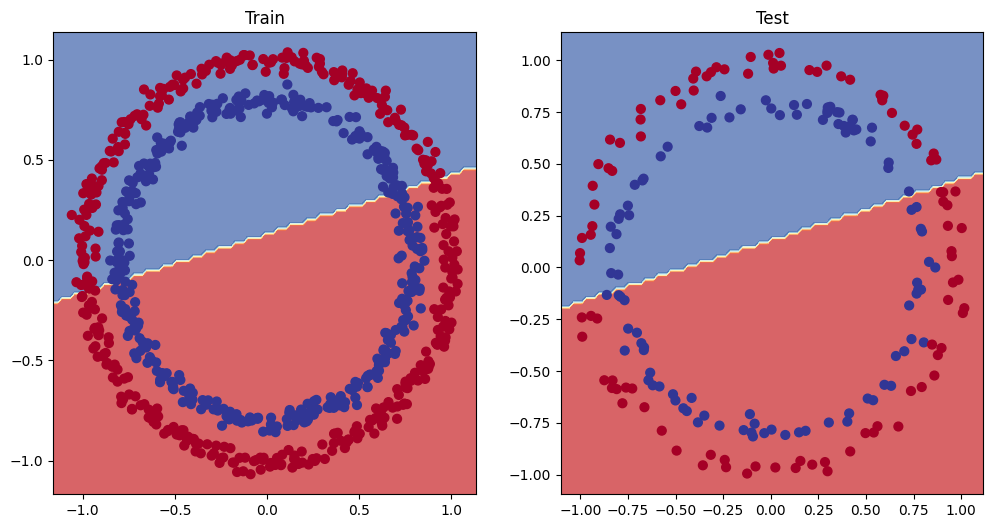

In [28]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

The model is trying to draw a straight line through our data even though it's circular. That's why it's not accurate at all!

In machine learning terms, our model is **underfitting**, meaning it's not learning predictive patterns from the data.

## 5. Improving Our Model

How?
- Add more layers
- Add more hidden units
- Fitting for longer (more epochs)
- Changing the activation functions
- Change the learning rate
- Change the loss function
- Use transfer learning

In [29]:
# New model
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 10)
        self.layer_2 = nn.Linear(10, 10) # extra layer
        self.layer_3 = nn.Linear(10, 1)
        
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [30]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [31]:
train_model(model_1, X_train, y_train, X_test, y_test, 1000, loss_fn, optimizer)

Epoch 0: Loss: 0.69483 | Accuracy: 50.00% | Test loss 0.69580 | Test accuracy 50.00%
Epoch 10: Loss: 0.69364 | Accuracy: 52.38% | Test loss 0.69500 | Test accuracy 49.50%
Epoch 20: Loss: 0.69343 | Accuracy: 50.88% | Test loss 0.69490 | Test accuracy 51.00%
Epoch 30: Loss: 0.69338 | Accuracy: 50.75% | Test loss 0.69489 | Test accuracy 49.00%
Epoch 40: Loss: 0.69334 | Accuracy: 51.00% | Test loss 0.69488 | Test accuracy 49.00%
Epoch 50: Loss: 0.69332 | Accuracy: 50.75% | Test loss 0.69487 | Test accuracy 49.00%
Epoch 60: Loss: 0.69329 | Accuracy: 50.62% | Test loss 0.69485 | Test accuracy 48.50%
Epoch 70: Loss: 0.69327 | Accuracy: 50.62% | Test loss 0.69484 | Test accuracy 49.00%
Epoch 80: Loss: 0.69325 | Accuracy: 51.50% | Test loss 0.69483 | Test accuracy 49.00%
Epoch 90: Loss: 0.69323 | Accuracy: 50.88% | Test loss 0.69482 | Test accuracy 49.50%
Epoch 100: Loss: 0.69321 | Accuracy: 51.00% | Test loss 0.69481 | Test accuracy 48.50%
Epoch 110: Loss: 0.69319 | Accuracy: 50.88% | Test los

Not much improvement!

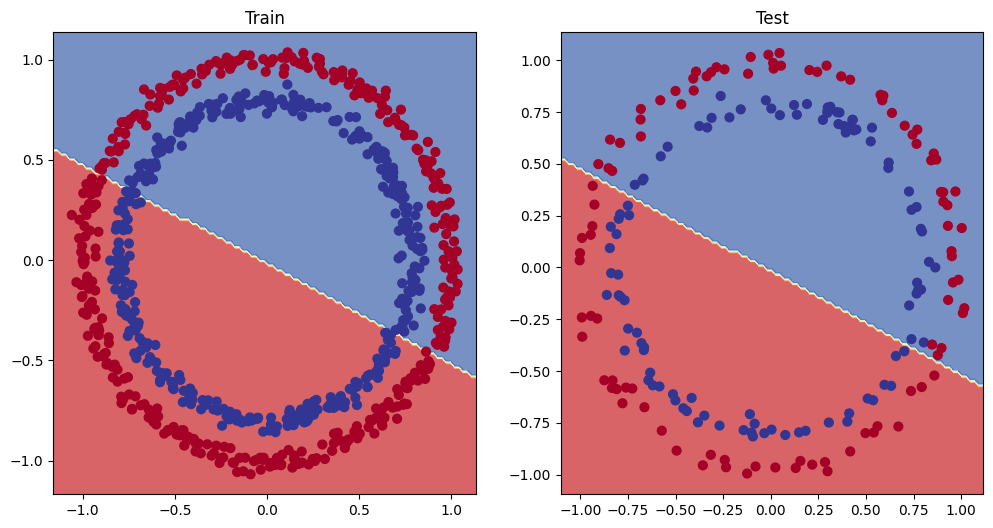

In [32]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 6. The Missing Piece: Non-Linearity

In [33]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 10)
        self.layer_2 = nn.Linear(10, 10)
        self.layer_3 = nn.Linear(10, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))) # put relu between each layers

In [34]:
model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [35]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [36]:
train_model(model_2, X_train, y_train, X_test, y_test, 1000, loss_fn, optimizer)

Epoch 0: Loss: 0.69313 | Accuracy: 50.00% | Test loss 0.69400 | Test accuracy 50.00%
Epoch 10: Loss: 0.69232 | Accuracy: 50.00% | Test loss 0.69332 | Test accuracy 50.00%
Epoch 20: Loss: 0.69154 | Accuracy: 50.00% | Test loss 0.69260 | Test accuracy 50.00%
Epoch 30: Loss: 0.69093 | Accuracy: 50.00% | Test loss 0.69211 | Test accuracy 50.00%
Epoch 40: Loss: 0.69050 | Accuracy: 50.38% | Test loss 0.69178 | Test accuracy 49.00%
Epoch 50: Loss: 0.69012 | Accuracy: 51.00% | Test loss 0.69148 | Test accuracy 51.00%
Epoch 60: Loss: 0.68974 | Accuracy: 52.00% | Test loss 0.69120 | Test accuracy 49.50%
Epoch 70: Loss: 0.68936 | Accuracy: 52.38% | Test loss 0.69091 | Test accuracy 49.00%
Epoch 80: Loss: 0.68896 | Accuracy: 53.62% | Test loss 0.69061 | Test accuracy 50.50%
Epoch 90: Loss: 0.68856 | Accuracy: 55.25% | Test loss 0.69032 | Test accuracy 54.00%
Epoch 100: Loss: 0.68816 | Accuracy: 56.88% | Test loss 0.69002 | Test accuracy 56.00%
Epoch 110: Loss: 0.68775 | Accuracy: 58.00% | Test los

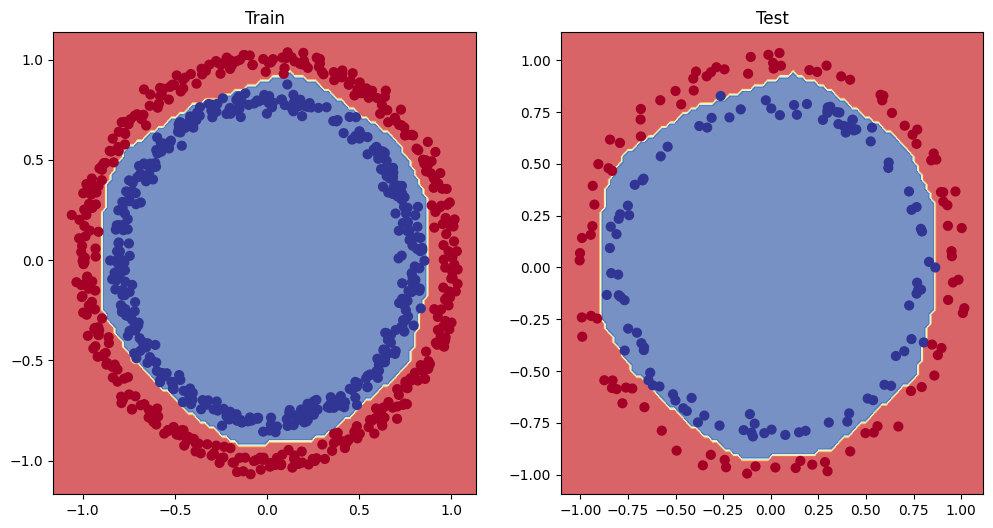

In [37]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

Finally!

## 8. Putting things together by building a multi-class PyTorch model¶

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


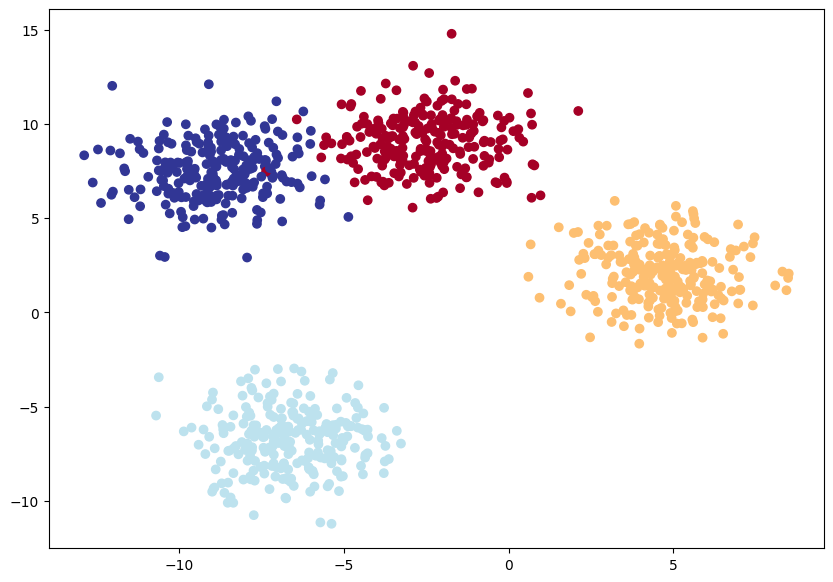

In [38]:
### Create data
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES, # X features
                            centers=NUM_CLASSES, # y labels
                            cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
                            random_state=RANDOM_SEED
                            )

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [71]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.ReLU(), # this dataset is simple enough that we actually don't need the ReLu layer
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_features)
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

In [72]:
model_4 = BlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES, hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [73]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

Let's check our model's performance before training!

In [74]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])


In [75]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.3169, 0.3244, 0.1405, 0.2182])
tensor(1)


At this point the model is just guessing. Let's now train our model!

In [76]:
torch.manual_seed(42)
epochs = 100
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()
    
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)
        
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")
    

Epoch: 0 | Loss: 1.15883, Acc: 40.38 | Test loss: 1.07554, Test acc: 48.00
Epoch: 10 | Loss: 0.64476, Acc: 96.75 | Test loss: 0.66069, Test acc: 97.50
Epoch: 20 | Loss: 0.42535, Acc: 98.50 | Test loss: 0.43074, Test acc: 100.00
Epoch: 30 | Loss: 0.25294, Acc: 99.12 | Test loss: 0.24508, Test acc: 99.50
Epoch: 40 | Loss: 0.11232, Acc: 99.25 | Test loss: 0.10229, Test acc: 99.50
Epoch: 50 | Loss: 0.06627, Acc: 99.25 | Test loss: 0.05848, Test acc: 99.50
Epoch: 60 | Loss: 0.05068, Acc: 99.25 | Test loss: 0.04293, Test acc: 99.50
Epoch: 70 | Loss: 0.04300, Acc: 99.25 | Test loss: 0.03491, Test acc: 99.50
Epoch: 80 | Loss: 0.03836, Acc: 99.25 | Test loss: 0.02988, Test acc: 99.50
Epoch: 90 | Loss: 0.03525, Acc: 99.25 | Test loss: 0.02663, Test acc: 99.50


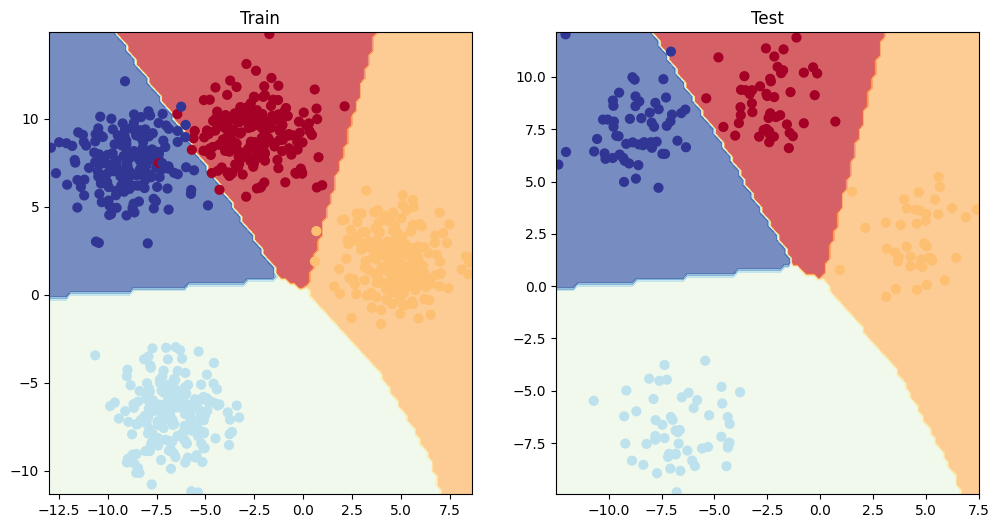

In [82]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [81]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
    
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%
